# Ottobot PID Tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ottobot_pid_helper import OttobotStepResponse, OttobotPidResponse

## Run initial step response
Duty at 150 out of 255 (~59%)

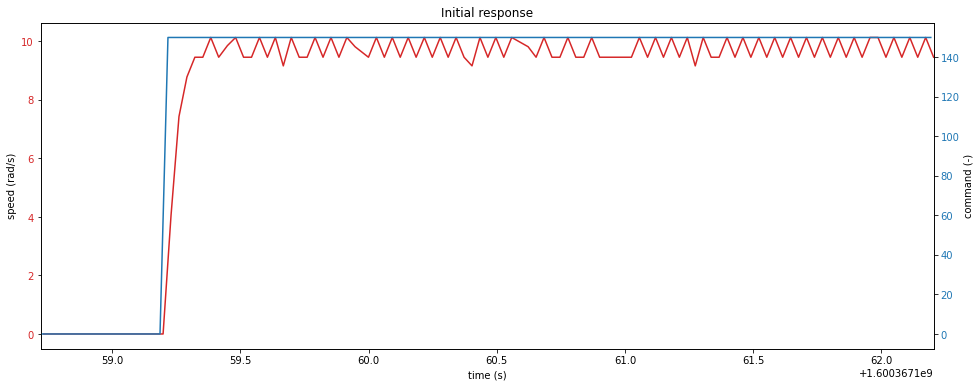

In [2]:
step_response_1 = OttobotStepResponse("pid_left_step150_v1.1.txt", title="Initial response")
step_response_1.plot_response()

A fair amount of noise can be seen in the wheel speed measurement. A filter should be applied to reduce this.

## Filter velocity measurement
### First order lag filter
A simple first order lag filter is applied to the velocity measurement:

```cpp
double speed_left_new = 1000 * TWO_PI * rotations_left / (double)(time_current - time_last_joint_udpate);
speed_left = speed_left * SPEED_FILTER_VAL + speed_left_new * (1 - SPEED_FILTER_VAL);
```

Initially the filter value is set at 0.5 and 0.8.

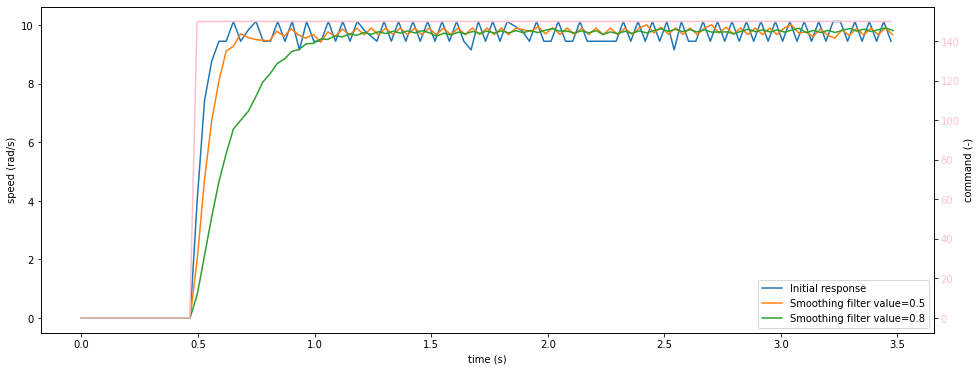

In [3]:
step_response_2 = OttobotStepResponse("pid_left_step150_v1.2.txt", title="Smoothing filter value=0.5")
step_response_3 = OttobotStepResponse("pid_left_step150_v1.3.txt", title="Smoothing filter value=0.8")
step_response_1.plot_against([step_response_2, step_response_3])
# step_response_2.plot_response()
# step_response_3.plot_response()

### Moving average filter
Now try a moving average filter.

The meat of the code looks like this, taking an average of a previous set of readings of size`MA_FILTER_WINDOW_SIZE`.

```cpp
ma_speed_left_sum -= ma_speed_left_readings[ma_speed_left_index];  // Remove the oldest entry from the sum
ma_speed_left_readings[ma_speed_left_index] = speed_left_new;  // Replace with new value in store
ma_speed_left_sum += speed_left_new;  // Add new value to sum
ma_speed_left_index = (ma_speed_left_index + 1) % MA_FILTER_WINDOW_SIZE;  // Increment index
speed_left = ma_speed_left_sum / MA_FILTER_WINDOW_SIZE;  // Average
```

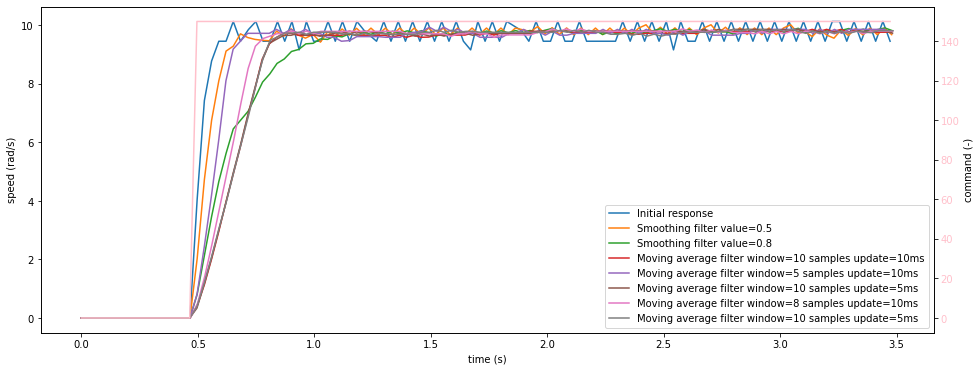

In [4]:
step_response_4 = OttobotStepResponse("pid_left_step150_v1.4.txt", title="Moving average filter window=10 samples update=10ms")
step_response_5 = OttobotStepResponse("pid_left_step150_v1.5.txt", title="Moving average filter window=5 samples update=10ms")
step_response_6 = OttobotStepResponse("pid_left_step150_v1.6.txt", title="Moving average filter window=10 samples update=5ms")
step_response_7 = OttobotStepResponse("pid_left_step150_v1.7.txt", title="Moving average filter window=8 samples update=10ms")
step_response_8 = OttobotStepResponse("pid_left_step150_v1.8.txt", title="Moving average filter window=10 samples update=5ms")
step_response_1.plot_against([step_response_2, step_response_3, step_response_4, step_response_5, step_response_6, step_response_7, step_response_8])

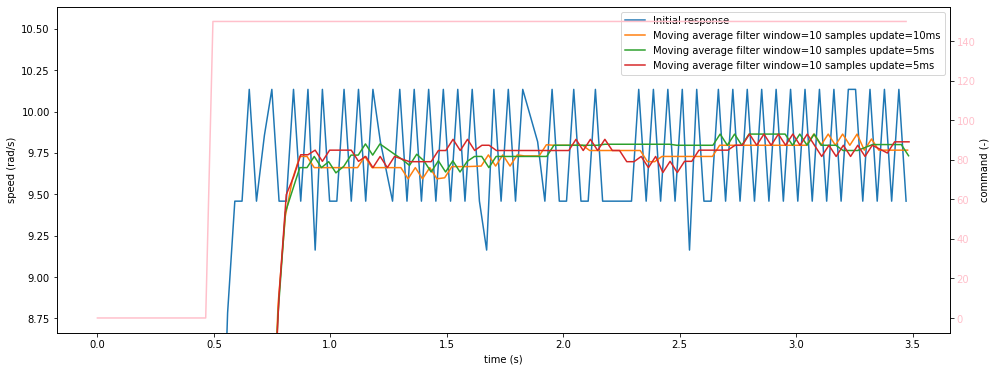

In [5]:
step_response_1.plot_against([step_response_4, step_response_6, step_response_8], zoom=True)

it looks like going up to a window size of >8 samples is required for a smooth response although this does give a significant lag to the step response. The results look signifiantly better then with the lag filter however. Lets see the chosen result:

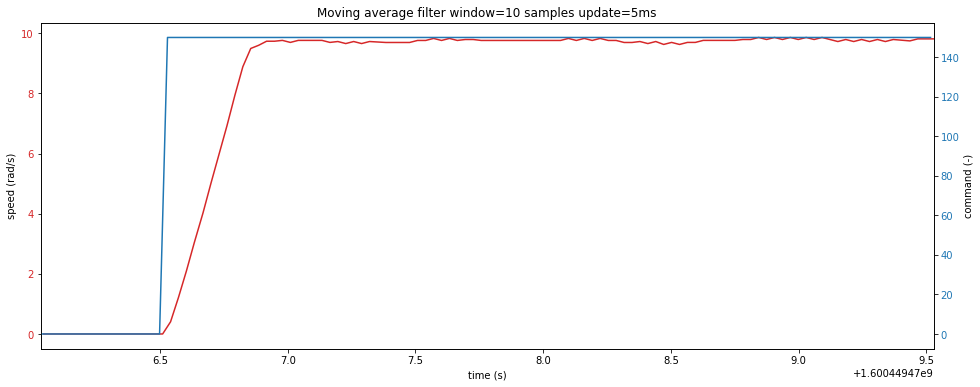

In [6]:
step_response_8.plot_response()

## Skogestad IMC tuning Method
[reference](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.623.275&rep=rep1&type=pdf)

In [7]:
# Zero start speed
w_0 = 0
# Find steady state speed
w_ss = step_response_7.get_steady_state_speed()
"Steady state speed = {0:.2f}rad/s".format(w_ss)

'Steady state speed = 9.77rad/s'

In [8]:
theta = step_response_7.get_response_delay()
"Response delay = {0:.4f}s".format(theta)

'Response delay = 0.0000s'

In [9]:
tau_1 = step_response_7.get_tau1()
"Time to 63% = {0:.3f}s".format(tau_1)

'Time to 63% = 0.188s'

In [10]:
t_ss = step_response_7.get_time_to_steady_state()
"Time to steady state = {0:.2f}s".format(t_ss)

'Time to steady state = 0.37s'

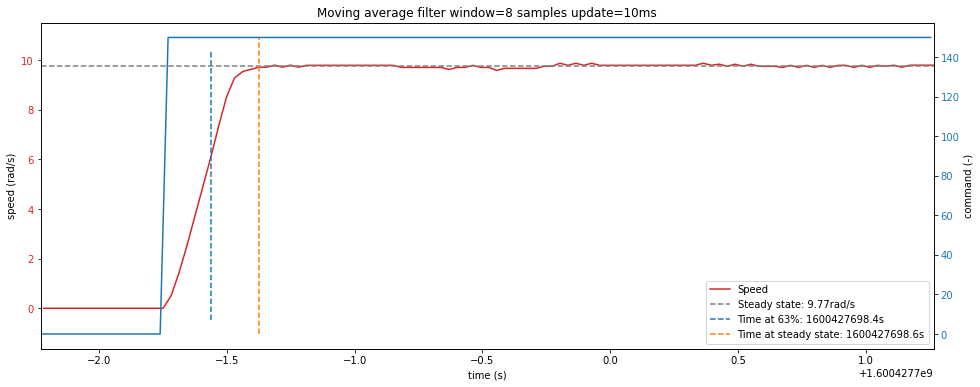

In [11]:
step_response_7.plot_response(show_SIMC=True)

The value to 63% required linear interpolation to find accurately.

In [12]:
u_step = 150
k = (w_ss - w_0) / u_step
# Need to tune this
tau_c = 0.01
K_c_cascade = tau_1 / (k * (tau_c + theta))
tau_I_cascade = tau_1
print("[K_c, tau_I] = [{:.1f}, {:.5f}]".format(K_c_cascade, tau_I_cascade))

[K_c, tau_I] = [288.4, 0.18790]


In [13]:
# Ideal PID
K_c = K_c_cascade
tau_I = tau_I_cascade

Kp = K_c
Ki = Kp / tau_I
Kd = 0

print("Gains: [{0:.1f}, {1:.1f}, {2:.0f}]".format(Kp, Ki, Kd))

Gains: [288.4, 1534.8, 0]


This seems mental, as the time delay is almost zero the suggested gains are huge. This method will not be used.

## PID without a PHD method
https://www.wescottdesign.com/articles/pid/pidWithoutAPhd.pdf

### Set proportional gain
Start with Kp low enough so there is no oscillation.
Lets choose Kp = 10

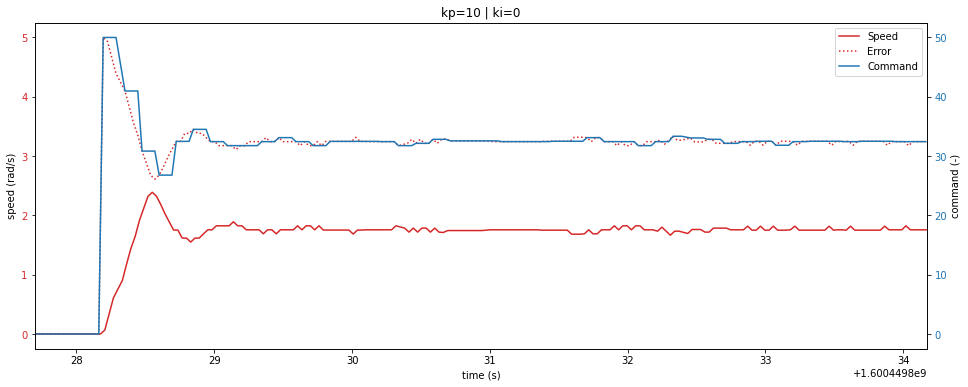

In [14]:
pid_response_p10 = OttobotPidResponse("pid_left_kp10_ki0_kd0_v1.3.txt", title="kp=10 | ki=0", delta_t_post_step=6)
pid_response_p10.plot_response()

Lets find the critical gain, where oscillations are undamped.

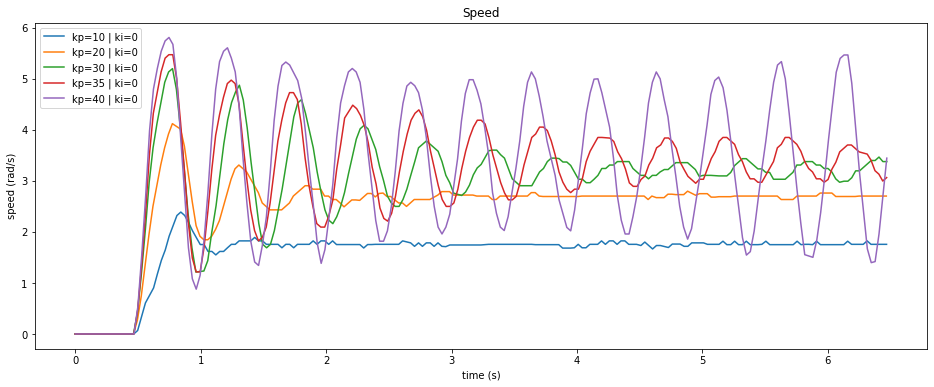

In [15]:
pid_response_p20 = OttobotPidResponse("pid_left_kp20_ki0_kd0_v1.1.txt", title="kp=20 | ki=0", delta_t_post_step=6)
pid_response_p30 = OttobotPidResponse("pid_left_kp30_ki0_kd0_v1.1.txt", title="kp=30 | ki=0", delta_t_post_step=6)
pid_response_p35 = OttobotPidResponse("pid_left_kp35_ki0_kd0_v1.1.txt", title="kp=35 | ki=0", delta_t_post_step=6)
pid_response_p40 = OttobotPidResponse("pid_left_kp40_ki0_kd0_v1.1.txt", title="kp=40 | ki=0", delta_t_post_step=6)
pid_response_p10.plot_against([pid_response_p20, pid_response_p30, pid_response_p35, pid_response_p40])

At kp = 40 the oscillations are undamped. Oscillations begin at about kp=20.

Now lets find the gain where there is no oscillation.

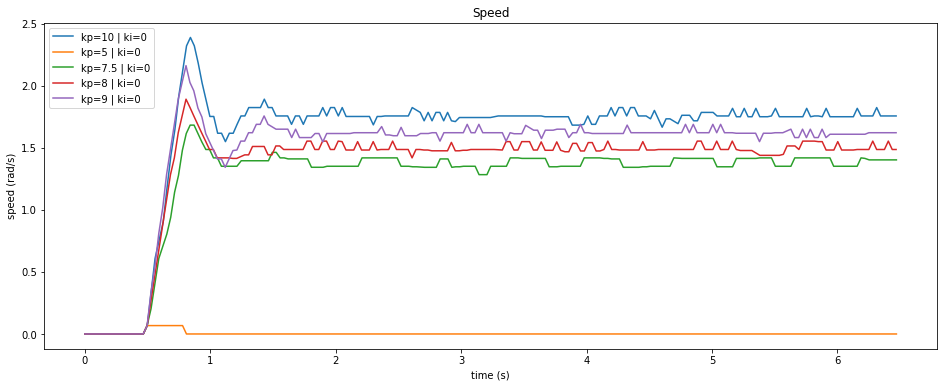

In [16]:
pid_response_p5 = OttobotPidResponse("pid_left_kp5_ki0_kd0_v1.1.txt", title="kp=5 | ki=0", delta_t_post_step=6)
pid_response_p7_5 = OttobotPidResponse("pid_left_kp7.5_ki0_kd0_v1.1.txt", title="kp=7.5 | ki=0", delta_t_post_step=6)
pid_response_p8 = OttobotPidResponse("pid_left_kp8_ki0_kd0_v1.1.txt", title="kp=8 | ki=0", delta_t_post_step=6)
pid_response_p9 = OttobotPidResponse("pid_left_kp9_ki0_kd0_v1.1.txt", title="kp=9 | ki=0", delta_t_post_step=6)
pid_response_p10.plot_against([pid_response_p5, pid_response_p7_5, pid_response_p8, pid_response_p9])

The guidelines say to now half or quarter the proportional gain at which oscillations start. If this is about kp = 20, kp = 5 is going to be too little so choose kp = 10.

### Integral gain
The starting value for ki is suggested as 1/100 kp which gives ki = 0.1.

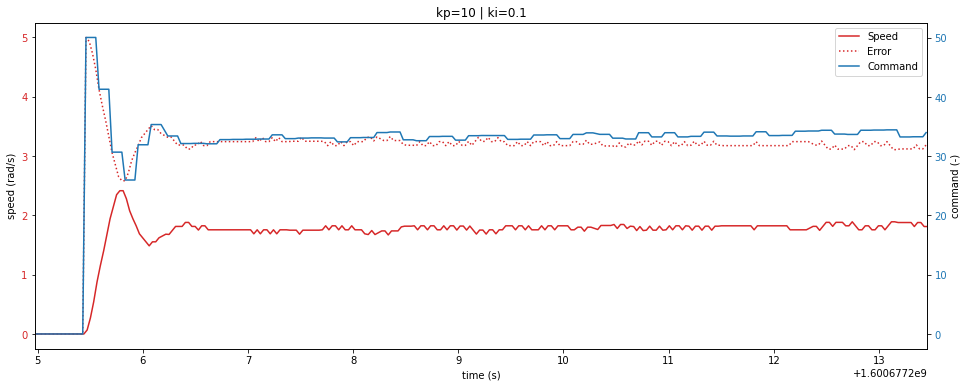

In [20]:
pid_response_p10_i0_1 = OttobotPidResponse("pid_left_kp10_ki0.1_kd0_v1.1.txt", title="kp=10 | ki=0.1", delta_t_post_step=8)
pid_response_p10_i0_1.plot_response()

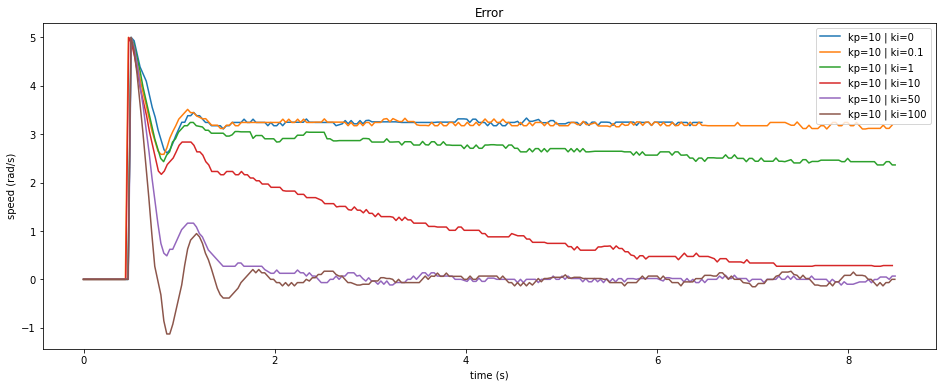

In [25]:
pid_response_p10_i1 = OttobotPidResponse("pid_left_kp10_ki1_kd0_v1.1.txt", title="kp=10 | ki=1", delta_t_post_step=8)
pid_response_p10_i10 = OttobotPidResponse("pid_left_kp10_ki10_kd0_v1.1.txt", title="kp=10 | ki=10", delta_t_post_step=8)
pid_response_p10_i100 = OttobotPidResponse("pid_left_kp10_ki100_kd0_v1.1.txt", title="kp=10 | ki=100", delta_t_post_step=8)
pid_response_p10_i50 = OttobotPidResponse("pid_left_kp10_ki50_kd0_v1.1.txt", title="kp=10 | ki=50", delta_t_post_step=8)
pid_response_p10.plot_against([pid_response_p10_i0_1, pid_response_p10_i1, pid_response_p10_i10, pid_response_p10_i50, pid_response_p10_i100], error=True)

Inspect the response, rather than error

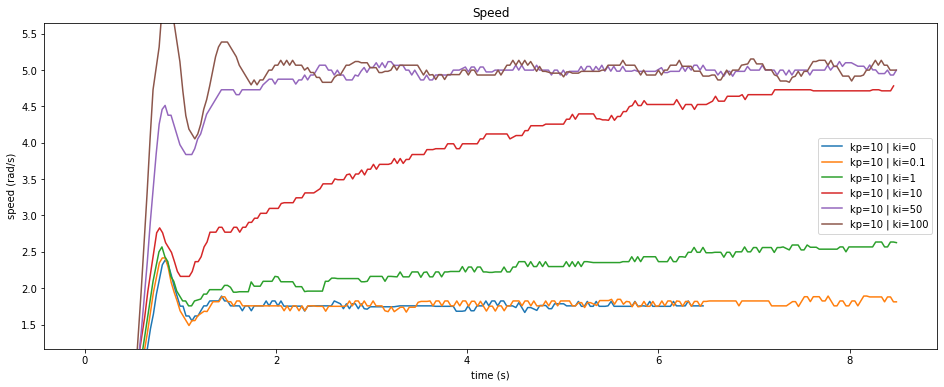

In [28]:
pid_response_p10.plot_against([pid_response_p10_i0_1, pid_response_p10_i1, pid_response_p10_i10, pid_response_p10_i50, pid_response_p10_i100], zoom=True)

Let's see what happens if we had chasen kp = 5.

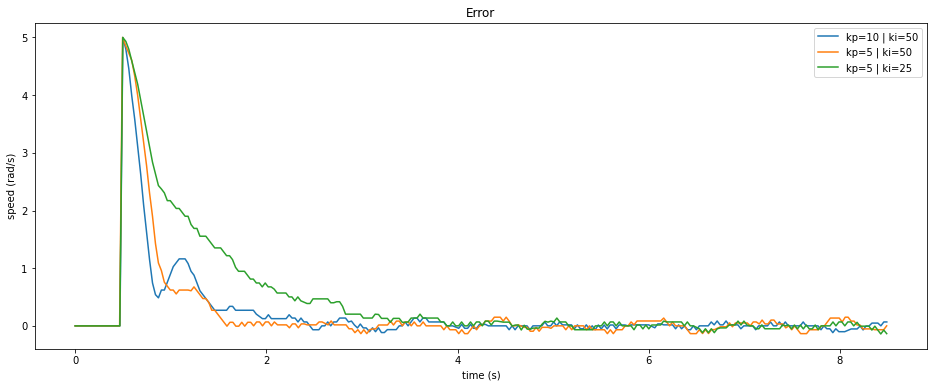

In [57]:
pid_response_p5_i100 = OttobotPidResponse("pid_left_kp5_ki100_kd0_v1.1.txt", title="kp=5 | ki=100", delta_t_post_step=8)
pid_response_p5_i50 = OttobotPidResponse("pid_left_kp5_ki50_kd0_v1.3.txt", title="kp=5 | ki=50", delta_t_post_step=8)
pid_response_p5_i25 = OttobotPidResponse("pid_left_kp5_ki25_kd0_v1.1.txt", title="kp=5 | ki=25", delta_t_post_step=8)
pid_response_p7_i25 = OttobotPidResponse("pid_left_kp7_ki25_kd0_v1.1.txt", title="kp=7 | ki=25", delta_t_post_step=8)
pid_response_p10_i50.plot_against([pid_response_p5_i50, pid_response_p5_i25], error=True)

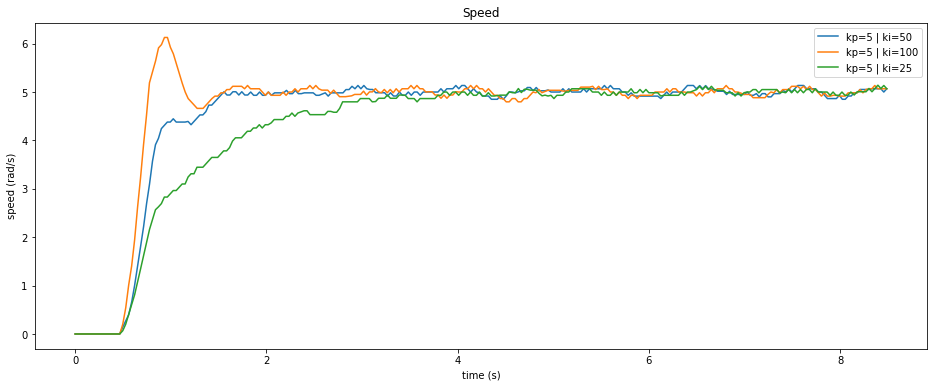

In [58]:
pid_response_p5_i50.plot_against([pid_response_p5_i100, pid_response_p5_i25])

It seems that taking a quarter of the proportional gain at which oscillations start works well. With kp = 5 there are significant oscilllations at ki = 100. Quartering this tp 25 gives a result which settles to 0 error without oscillation.

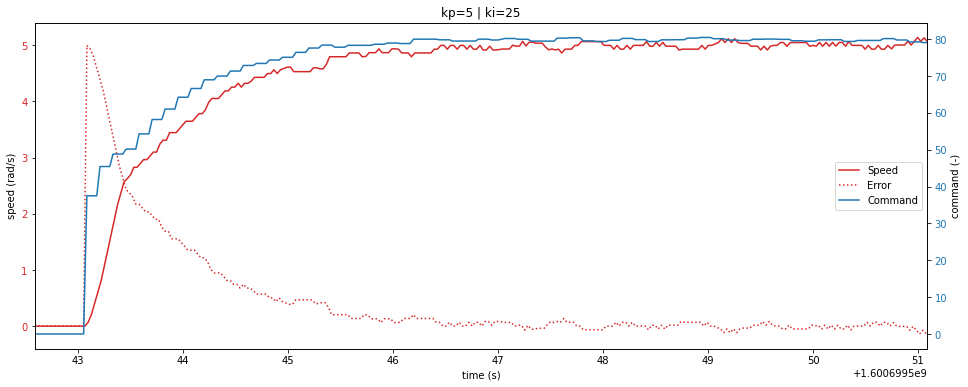

In [55]:
pid_response_p5_i25.plot_response()

There is a problem when commanding zero speed where there is a constant error:

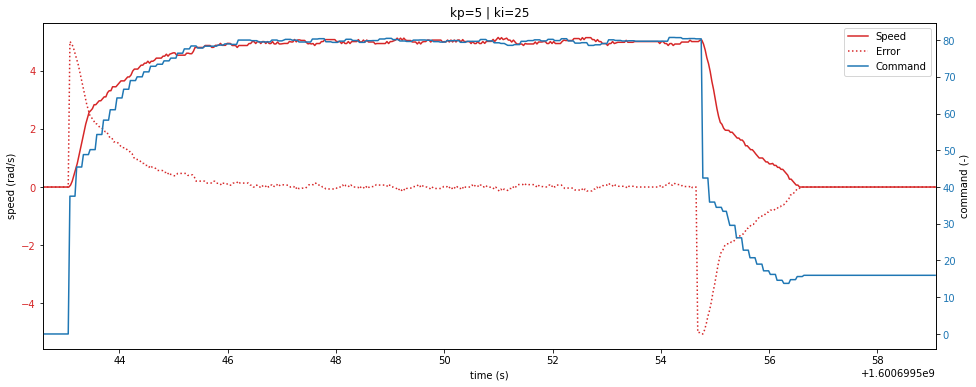

In [61]:
pid_response_p5_i25_full = OttobotPidResponse("pid_left_kp5_ki25_kd0_v1.1.txt", title="kp=5 | ki=25", delta_t_post_step=16)
pid_response_p5_i25_full.plot_response()

As can be seen a constant output of approx. 16 results when the setpoint is changed from high (5 rad/s) to 0 rad/s. The actual speed at this point is very close to, but not quite, zero. The sampling time was increased, thinking this might improve the speed measurement at low speeds but it did not help.



# PID
Breaks into oscillations at kd=10 (kp=10), set kd=2.5  
Breaks into oscillations at kp=40 (kd=2.5), set kp=10  
Breaks into oscillations at ki=80 (kp=10, kd=2.5), set ki=20

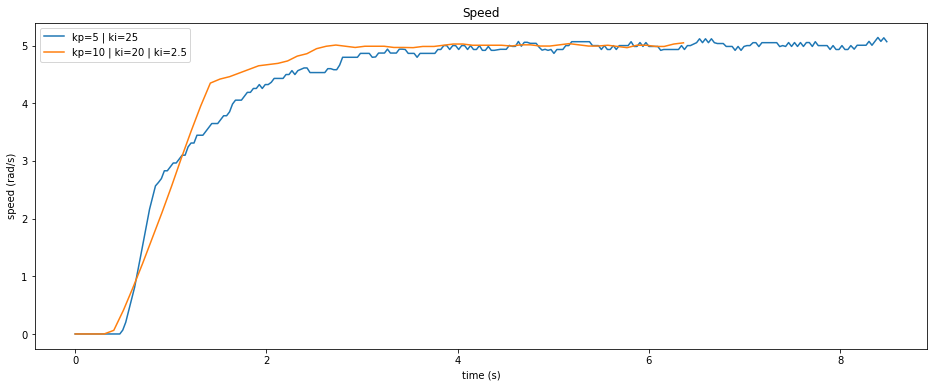

In [70]:
pid_response_p10_i20_d2_5 = OttobotPidResponse("pid_left_kp10_ki20_kd2.5_v1.1.txt", title="kp=10 | ki=20 | ki=2.5", delta_t_post_step=6)
pid_response_p5_i25.plot_against([pid_response_p10_i20_d2_5])